# Spam Mail Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PeaceTwinkle/NMKHDL-spam/blob/main/SpamMailClassificationProject_HuynhVanTuAn_207KD40106.ipynb)

## Introduction

Why classifying spam mails is important, at what cost, how will the chosen approach help?

In this project, our team will apply the data science process, tools and techniques to classify [the public data sets of normal and spam mails](https://spamassassin.apache.org/old/publiccorpus/) distributed by Apache [Spam Assassin](https://spamassassin.apache.org/), the top open-source anti-spam platform. 

Our objective is to classify spams based on **email content**. 

## Methodology

### Set up environment
To deal with spam emails in the form of text files, we'll need to use some standard library packages that were installed when we set up Python on our local machine: [os](https://docs.python.org/3.6/library/os.html) and [email](https://docs.python.org/3.6/library/email.html). 

`Email` is a library for ... 

Modules `model_selection`, ... of `scikit-learn`

In [16]:
import os
import email
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

#enable autocomplete by Tab
%config IPCompleter.greedy=True 
# display graphs in jupyter cells
%matplotlib inline 

### Store all file names as lists

There are more than 1 data structure suitable for this task, but we chose lists due to the ease of iterating, enumerating through their elements and manipulating them on the fly. Moreover, we only have 2 categories, so dictionary may be an overkill.

In [38]:
path = 'data/'
easy_ham_paths = [path+'easy_ham/'+ file for file in os.listdir(path+'easy_ham/')]
easy_ham_2_paths = [path+'easy_ham_2/'+ file for file in os.listdir(path+'easy_ham_2/')]
hard_ham_paths = [path+'hard_ham/'+ file for file in os.listdir(path+'hard_ham/')]
spam_paths = [path+'spam/'+ file for file in os.listdir(path+'spam/')]
spam_2_paths = [path+'spam_2/'+ file for file in os.listdir(path+'spam_2/')]

Take note that the command `os.listdir(path)` returns a list of all file names in the `path`, but they are not the absolute path required by `os` to open and read a file. Thus, we need to append the directory to each file name. 

A simpler way to save file names with absolute path is to use the [glob](https://docs.python.org/3.6/library/glob.html) standard Python library by calling `glob.glob(path +'/*')`. Since this step is the only time we might need to use this library, we went ahead with the `os` approach. Also, our data set has a relatively small number of files, so using some extra loops is still acceptable.


### Read email content

First, we checked the content of 1 normal email in the easy category

In [7]:
with open(easy_ham_paths[0], mode='r') as file:
    print(file.read())


From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

There are a lot of details about the sender's and receiver's email addresses such as domains, IP addresses, etc. Most of this information is useful for a cybersecurity specialist, but we are tackling this problem from a data scientist's point of view, so we will first try to look at only the email content according to our predefined objective.

To effectively achieve that goal, we will use `email` package to extract the content of emails. Sometimes, only type `text/plain` is needed, we can set the condition as `if email.get_content_type() == 'text/plain'`, but most modern emails contain html tags, etc., and may not be associated with one exact type. The data structure of most email messages is a tree, each branch of which may belong to a different [content type](https://docs.python.org/3/library/email.message.html#email.message.EmailMessage.walk). 

In [26]:
def get_email_content(email_path):
    with open(email_path,encoding='latin1') as file:
        try:
            msg = email.message_from_file(file)
            for part in msg.walk():
                return part.get_payload() 
        except Exception as e:
            print(e)
            
print(get_email_content(easy_ham_paths[0]))

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55

### Data Mining

![Garbage in, Garbage out by accutrend](http://www.accutrend.com/wp-content/uploads/2018/07/GiGo-570x315.jpg)

#### Basic exploratory data analysis (EDA)

We tried to first visualize numeric features of the dataset such as the number of emails in each class, the statistics of email lengths for each class. 

**1. Bar graph of 2 classes**

<BarContainer object of 2 artists>

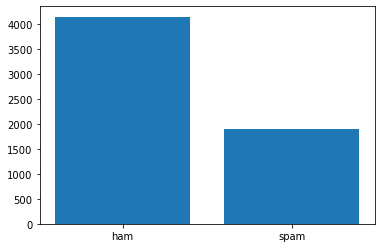

In [39]:
spam_amount = len(spam_paths)+len(spam_2_paths)
ham_amount = len(easy_ham_paths)+len(easy_ham_2_paths)+len(hard_ham_paths)
plt.bar(['ham', 'spam'], [ham_amount, spam_amount])

**2. Box plots of email lengths**

We created box plots for the email lengths in 2 classes and removed outliers since there are too many of them

{'whiskers': [<matplotlib.lines.Line2D at 0x1fbf4b100b8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fbf4b10668>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fbf4b1ae10>,
 'medians': [<matplotlib.lines.Line2D at 0x1fbf4b10c18>,
 'fliers': [],
 'means': []}

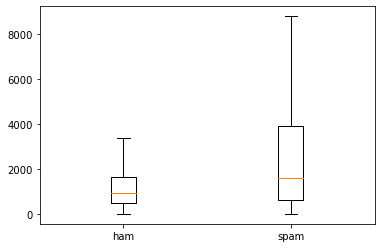

In [45]:
spam_mail_lengths = [len(get_email_content(file)) for file in spam_paths]
for file in spam_2_paths:
    spam_mail_lengths.append(len(get_email_content(file)))
    
ham_mail_lengths = [len(get_email_content(file)) for file in easy_ham_paths]
for file in easy_ham_2_paths:
    ham_mail_lengths.append(len(get_email_content(file)))
for file in hard_ham_paths:
    ham_mail_lengths.append(len(get_email_content(file)))
    
plt.boxplot([ham_mail_lengths, spam_mail_lengths], labels=['ham','spam'],showfliers=False)

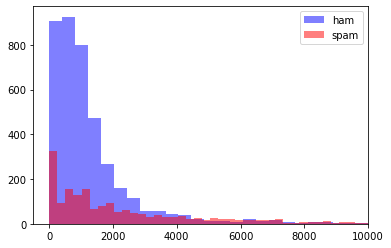

In [63]:
kwargs = dict(alpha=0.5, bins=500)
plt.hist(ham_mail_lengths,  **kwargs, color='b', label='ham')
plt.hist(spam_mail_lengths,  **kwargs, color='r', label='spam')
plt.xlim(-500,10000)
plt.legend()

In [65]:
0 in spam_mail_lengths

False

#### Pre-processing

##### Clean-up pipeline

1. Remove punctuations
2. Remove whitespaces
3. Remove special characters if any
4. Remove HTML tags if any
5. Convert to lower case


For the simplicity of this project, we will also remove all hyperlinks and numbers, even though they can be useful features to boost classification accuracy. 

In [ ]:
def clean_up_pipeline(text):
    
    # remove hyperlinks
    text = re.sub(r"http\S+", "", text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove punctuations
    text = text.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    
    # remove whitespace
    
    text = text.strip()
    
    return text

In [11]:
a = "fdfasdf"
b = (a+" ")[:-1]
print(id(a), id(b))

2181533957232 2181591309928


## Reference

1. [Email Spam Detection Python repo by Sie Huai Gan](https://github.com/huai99/Email-Spam-Detection-Python)
2. [NLP Text Preprocessing: A practical guide and template](https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79)